# Capture Picture from camera


image 1/1 c:\Users\adrianishak.duda\OneDrive - Hexagon\Documents\Experiment\Python\ComputerVision\camera_image.jpg: 736x960 (no detections), 446.5ms
Speed: 17.2ms preprocess, 446.5ms inference, 19.1ms postprocess per image at shape (1, 3, 736, 960)
Results saved to C:\Users\adrianishak.duda\OneDrive - Hexagon\Documents\Experiment\Python\ComputerVision\runs\detect\predict26


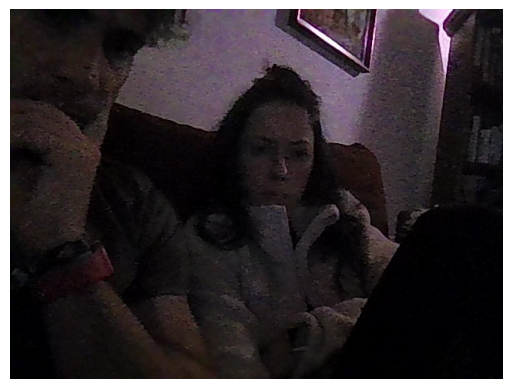

In [1]:
# make picture from camera and predict it with yolo
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()
if ret:
    cv2.imwrite("camera_image.jpg", frame)
    model = YOLO("yolo11n.pt")
    results = model.predict(source="camera_image.jpg", imgsz=960, conf=0.25, save=True)

    res = results[0]
    img = res.plot()  # BGR
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.show()

# Capture Stream from camera

In [2]:
# now capture video from camera and predict it with yolo in real-time with saliency map
import cv2
import numpy as np
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
cap = cv2.VideoCapture(0)

# Create saliency detector
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # YOLO detection
    results = model.predict(source=frame, imgsz=320, conf=0.25, verbose=False)
    img_yolo = results[0].plot()  # BGR
    
    # Compute saliency map
    (success, saliencyMap) = saliency.computeSaliency(frame)
    saliencyMap = (saliencyMap * 255).astype("uint8")
    
    # Convert saliency map to 3-channel for display
    saliency_colored = cv2.applyColorMap(saliencyMap, cv2.COLORMAP_JET)
    
    # Display windows
    cv2.imshow("YOLO11n Real-Time Detection", img_yolo)
    cv2.imshow("Saliency Map", saliency_colored)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Programm beendet.")

Programm beendet.


## Was zeigt die Saliency Map?

Die **Saliency Map** (Auffälligkeitskarte) visualisiert, welche Bereiche im Bild visuell hervorstechen:

- **Rote/Gelbe Bereiche**: Hohe Salienz - Bereiche die stark auffallen (Kanten, Kontraste, ungewöhnliche Texturen)
- **Blaue/Dunkle Bereiche**: Niedrige Salienz - Bereiche die wenig auffallen (gleichmäßige Flächen, Hintergrund)

**Anwendungen:**
- Zeigt wo das menschliche Auge hinschauen würde
- Identifiziert wichtige Bildbereiche automatisch  
- Kann bei der Objekterkennung helfen
- Nützlich für Bildkompression und -analyse

**Unterschied zu YOLO:** 
- YOLO erkennt spezifische Objekte (Person, Auto, etc.)
- Saliency Map zeigt visuell auffällige Bereiche (unabhängig vom Objekttyp)

# SURF Keypoint Detection Stream

In [3]:
# Real-time camera stream with YOLO, Saliency Map and SURF Keypoints
import cv2
import numpy as np
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
cap = cv2.VideoCapture(0)

# Create SURF detector (requires opencv-contrib-python)
try:
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold=400)
    surf_available = True
except AttributeError:
    # Fallback to ORB if SURF not available
    surf = cv2.ORB_create(nfeatures=500)
    surf_available = False
    print("SURF nicht verfügbar, verwende ORB als Alternative")

def compute_saliency_map(frame):
    """Compute saliency map using spectral residual method"""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    f_transform = np.fft.fft2(blurred)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shift) + 1)
    blurred_spectrum = cv2.GaussianBlur(magnitude_spectrum, (3, 3), 0)
    spectral_residual = magnitude_spectrum - blurred_spectrum
    
    f_ishift = np.fft.ifftshift(np.exp(spectral_residual + 1j * np.angle(f_shift)))
    saliency = np.abs(np.fft.ifft2(f_ishift))
    saliency = cv2.GaussianBlur(saliency, (11, 11), 2.5)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
    return (saliency * 255).astype(np.uint8)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # YOLO detection
    results = model.predict(source=frame, imgsz=320, conf=0.25, verbose=False)
    img_yolo = results[0].plot()
    
    # Saliency map
    saliencyMap = compute_saliency_map(frame)
    saliency_colored = cv2.applyColorMap(saliencyMap, cv2.COLORMAP_JET)
    
    # SURF/ORB Keypoint detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    keypoints = surf.detect(gray, None)
    img_keypoints = cv2.drawKeypoints(frame, keypoints, None, (0, 255, 0), 2)
    
    # Display windows
    cv2.imshow("YOLO Detection", img_yolo)
    cv2.imshow("Saliency Map", saliency_colored)
    cv2.imshow("SURF/ORB Keypoints", img_keypoints)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Programm beendet.")

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv_contrib\modules\xfeatures2d\src\surf.cpp:1028: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'cv::xfeatures2d::SURF::create'


## SURF vs ORB - Keypoint Detektoren

### Warum ist SURF nicht verfügbar?

**SURF (Speeded-Up Robust Features)** ist patentiert und daher:
- Nicht in der Standard OpenCV Installation enthalten
- Benötigt `opencv-contrib-python` Package
- Kommerzielle Nutzung kann lizenzpflichtig sein
- Wurde aus rechtlichen Gründen in neueren OpenCV Versionen eingeschränkt

### Was ist ORB?

**ORB (Oriented FAST and Rotated BRIEF)** ist eine freie Alternative:
- **Open Source** und patentfrei
- In Standard OpenCV enthalten
- Schneller als SURF
- Robust gegen Rotation und Skalierung
- Entwickelt von OpenCV Team als SURF-Ersatz

### Vergleich:
| Feature | SURF | ORB |
|---------|------|-----|
| **Lizenz** | Patentiert | Open Source |
| **Geschwindigkeit** | Mittel | Sehr schnell |
| **Genauigkeit** | Hoch | Gut |
| **Verfügbarkeit** | opencv-contrib | Standard OpenCV |
| **Speicher** | Mehr | Weniger |

**Fazit:** ORB ist meist die bessere Wahl für die meisten Anwendungen!